<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/Modeling_and_Prediction_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM BASELINE MODEL

In diesem Skript wird ein erstes Modell erzeugt, um aus den gemssenen Globalstrahlungsdaten den UVI zu berechen.

In [1]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow
!pip install keras

In [3]:
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
# Pfad zur CSV-Datei auf Google-Drive
name_Messwerte = 'Messdaten_CAMS_GHI.csv'
name_Vorhersage = 'Vorhersagedaten_CAMS_VarIdx.csv'
folder_import = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'

In [5]:
# Pfad zum Abspeichern des trainierten Modells in Google-Drive

model_path = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/full_model.keras'
weights_path = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_weights.weights.h5'

# Pfad für den Testdatensatz

testdata_path = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_testdata.csv'

In [6]:
# Import der Messdaten
df_Messdaten = pd.read_csv(folder_import + name_Messwerte)

In [7]:
# Import der Vorhersagedaten
df_Vorhersage = pd.read_csv(folder_import + name_Vorhersage)

In [8]:
# Konvertiere die Zeitspalten in ein gemeinsames Format und führe einen Merge der Datensätze durch
df_Messdaten['Datetime'] = pd.to_datetime(df_Messdaten['Datetime'])
df_Vorhersage['Datetime'] = pd.to_datetime(df_Vorhersage['Datetime'])

In [9]:
# Spalten in den Messdaten
df_Messdaten.columns

Index(['Datetime', 'Observation_period', 'Clear_sky_GHI', 'Clear_sky_BHI',
       'GHI', 'BHI', 'UVI', 'UVA', 'UVB', 'erythem', 'Datum', 'Uhrzeit',
       'Messzeitpunkt', 'ghi', 'Dif', 'Glo_SPLite', 'Dir', 'Temp',
       'DiffGreater2', 'SZA', 'time_sin', 'time_cos', 'date_sin', 'date_cos',
       'Date', 'Hour'],
      dtype='object')

In [10]:
# Beispiel: Nur 'SZA' als Feature und 'UVI' als Label
columns_X = ['SZA']
columns_y = ['UVI']

df = df_Messdaten.copy()  # deine Messdaten

total_length = len(df)
train_size   = round(total_length * 0.80)
val_size     = round(total_length * 0.10)
test_size    = total_length - train_size - val_size  # restliche 10%

# Skaliere X und Y separat (immer zuerst nur auf dem Trainingsbereich fitten!)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# 1) Nur Trainingsdatensatz extrahieren
train_df = df.iloc[:train_size]
# Fit des Scalers NUR auf Trainingsdaten
train_df[columns_X] = scaler_X.fit_transform(train_df[columns_X])
train_df[columns_y] = scaler_y.fit_transform(train_df[columns_y])

# 2) Für Validation
val_df = df.iloc[train_size : train_size + val_size].copy()
val_df[columns_X] = scaler_X.transform(val_df[columns_X])
val_df[columns_y] = scaler_y.transform(val_df[columns_y])

# 3) Für Test
test_df = df.iloc[train_size + val_size :].copy()
test_df[columns_X] = scaler_X.transform(test_df[columns_X])
test_df[columns_y] = scaler_y.transform(test_df[columns_y])

# Kontrolle
print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

Train: (77386, 26)
Val: (9673, 26)
Test: (9673, 26)


<ipython-input-10-e1bd31bd9920>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[columns_X] = scaler_X.fit_transform(train_df[columns_X])
<ipython-input-10-e1bd31bd9920>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[columns_y] = scaler_y.fit_transform(train_df[columns_y])


In [11]:
def create_sequence(X, y, seq_length):
    sequences = []
    labels = []
    for stop_idx in range(seq_length, len(X)):
        x_seq = X.iloc[stop_idx-seq_length:stop_idx].values  # (seq_length, num_features)
        y_label = y.iloc[stop_idx]                           # Wert am Zeitpunkt 'stop_idx'
        sequences.append(x_seq)
        labels.append(y_label)
    return np.array(sequences), np.array(labels)

In [12]:
def create_sequence_OneStepAhead(X, y, seq_length):
    sequences = []
    labels = []
    # bis len(X)-1, damit "stop_idx + 1" nicht out-of-range ist
    for stop_idx in range(seq_length, len(X)-1):
        x_seq = X.iloc[stop_idx-seq_length:stop_idx].values
        y_label = y.iloc[stop_idx + 1]  # => label ist der nächste Zeitschritt
        sequences.append(x_seq)
        labels.append(y_label)
    return np.array(sequences), np.array(labels)

In [13]:
sequence_len = 16

X_train_seq, y_train_seq = create_sequence(train_df[columns_X], train_df[columns_y], sequence_len)
X_val_seq,   y_val_seq   = create_sequence(val_df[columns_X],   val_df[columns_y],   sequence_len)
X_test_seq,  y_test_seq  = create_sequence(test_df[columns_X],  test_df[columns_y],  sequence_len)

print(X_train_seq.shape, y_train_seq.shape)
print(X_val_seq.shape,   y_val_seq.shape)
print(X_test_seq.shape,  y_test_seq.shape)

(77370, 16, 1) (77370, 1)
(9657, 16, 1) (9657, 1)
(9657, 16, 1) (9657, 1)


In [14]:
input_shape = (16, 1)

In [15]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units=32))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
history = model.fit(X_train_seq, y_train_seq,
          validation_data=(X_val_seq, y_val_seq),
          epochs=10, batch_size=32)

Epoch 1/10
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 60s 21ms/step - loss: 0.0093 - mean_absolute_error: 0.0581 - val_loss: 0.0188 - val_mean_absolute_error: 0.0850
Epoch 2/10
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 50s 21ms/step - loss: 0.0068 - mean_absolute_error: 0.0480 - val_loss: 0.0147 - val_mean_absolute_error: 0.0777
Epoch 3/10
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 50s 21ms/step - loss: 0.0067 - mean_absolute_error: 0.0474 - val_loss: 0.0177 - val_mean_absolute_error: 0.0827
Epoch 4/10
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 81s 20ms/step - loss: 0.0067 - mean_absolute_error: 0.0472 - val_loss: 0.0164 - val_mean_absolute_error: 0.0786
Epoch 5/10
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - loss: 0.0066 - mean_absolute_error: 0.0464 - val_loss: 0.0167 - val_mean_absolute_error: 0.0795
Epoch 6/10
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - loss: 0.0067 - mean_absolute_error: 0.0468 - val_loss: 0.0152 - val_mean_absolute_error: 0.0773
Epoch 7/10
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - loss: 0.0066 - mea

In [47]:
# Berechnen des vorhergesagten UVI
y_pred = model.predict(X_test_seq)

302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [58]:
y_pred = y_pred.flatten()
y_test_seq = y_test_seq.flatten()

In [66]:
type(y_pred)

numpy.ndarray

In [59]:
# Püfen, ob die Vorhersage den selben Shape hat wie
print(y_pred.shape, y_test_seq.shape)

(9657,) (9657,)


In [60]:
# Abspeichern des trainierten Modells und der Gewichte

model.save(model_path)
model.save_weights(weights_path)

# Abspeichern des Testdatensatzes für eine spätere Auswertung

## Berechnung der Qualitätsparameter:

In [61]:
def compare_model_output(model, X_test, y_test, plot_indices=None):
    """
    Vergleicht den Output des Modells mit den wahren Testdaten.

    Parameter:
    -----------
    model : keras.Model
        Das trainierte Modell.
    X_test : np.array
        Die Eingabedaten (Sequenzen) für den Test.
    y_test : np.array
        Die tatsächlichen Zielwerte (Labels) für den Test.
    plot_indices : tuple or list (optional)
        Falls angegeben, z.B. (start, end), wird nur dieser Abschnitt für einen Detailplot verwendet.
    """

    # Vorhersage berechnen
    y_pred = model.predict(X_test)
    # Arrays abflachen für leichtere Handhabung
    y_pred = y_pred.flatten()
    y_test = y_test.flatten()

    # Metriken berechnen
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Ergebnis ausgeben
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    # Gesamten Vergleich plotten
    plt.figure(figsize=(12, 4))
    plt.plot(y_pred, label='Vorhersage', alpha=0.7)
    plt.plot(y_test, label='Tatsächlicher Wert', alpha=0.7)
    plt.title('Vergleich Vorhersage vs. Tatsächlicher Wert')
    plt.legend()
    plt.show()

    # Optionaler Detailplot für einen Index-Bereich
    if plot_indices is not None:
        start, end = plot_indices
        plt.figure(figsize=(12, 4))
        plt.plot(np.arange(start, end), y_pred[start:end], label='UVI Vorhersage', alpha=0.7)
        plt.plot(np.arange(start, end), y_test[start:end], label='UVI Messung', alpha=0.7)
        plt.title(f'Detailplot (Index {start} - {end})')
        plt.legend()
        plt.show()

302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Mean Squared Error (MSE): 0.0223
Mean Absolute Error (MAE): 0.0984


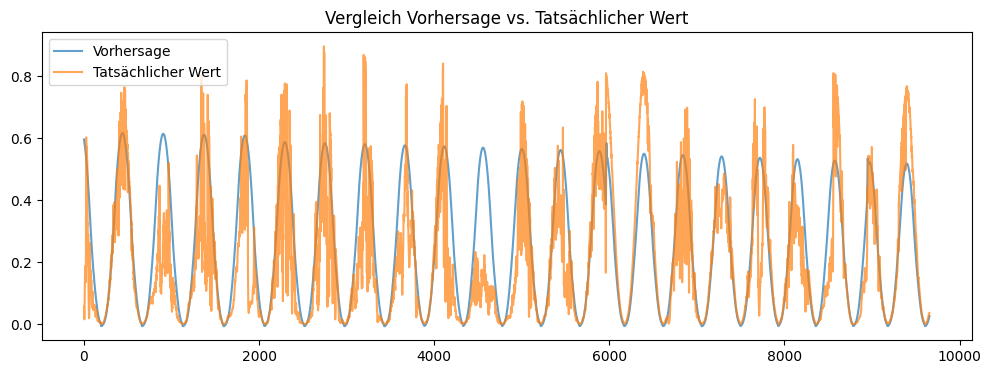

In [62]:
compare_model_output(model, X_test_seq, y_test_seq, plot_indices=None)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Mean Squared Error (MSE): 0.0201
Mean Absolute Error (MAE): 0.0862


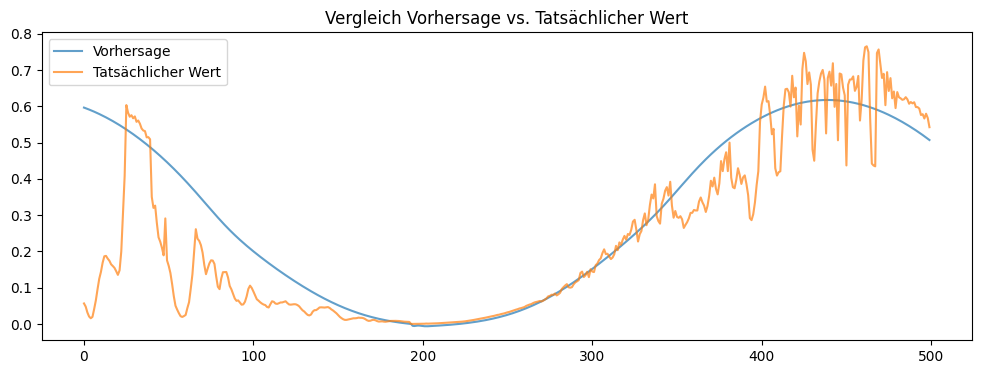

In [63]:
compare_model_output(model, X_test_seq[:500], y_test_seq[:500], plot_indices=None)

In [64]:
def plot_largest_deviation(y_pred, y_true, window=250):
    """
    Findet die größte Abweichung zwischen Vorhersage und Messwerten und plottet
    den Bereich von [i-window, i+window] um diesen Index herum.

    Parameter:
    -----------
    y_pred : np.array
        Array der Vorhersagewerte (z.B. Modelloutput).
    y_true : np.array
        Array der gemessenen True-Werte (Labels).
    window : int, optional (default=250)
        Anzahl an Werten vor und nach dem Index der größten Abweichung,
        die im Detailplot dargestellt werden sollen.

    Returns:
    -----------
    None (erstellt ein Plot).
    """

    # Sicherstellen, dass beide Arrays gleich lang sind
    if len(y_pred) != len(y_true):
        raise ValueError(f"Inkonsistente Längen: y_pred={len(y_pred)}, y_true={len(y_true)}")

    # Index der größten Abweichung bestimmen
    diff = np.abs(y_pred - y_true)
    max_idx = np.argmax(diff)

    # Anzeigebereich für den Plot definieren (Begrenzung beachten)
    start_idx = max(0, max_idx - window)
    end_idx = min(len(y_pred), max_idx + window)

    # Plot erstellen
    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(start_idx, end_idx), y_true[start_idx:end_idx],
             label='Messwerte (y_val)', alpha=0.7)
    plt.plot(np.arange(start_idx, end_idx), y_pred[start_idx:end_idx],
             label='Vorhersage (y_pred)', alpha=0.7)
    # Hervorhebung des Punktes mit größter Abweichung
    plt.scatter(max_idx, y_true[max_idx], color='red', s=80, marker='x', label='Größte Abweichung')

    plt.title(f'Größte Abweichung bei Index={max_idx} (Abweichung={diff[max_idx]:.4f})')
    plt.xlabel('Index')
    plt.ylabel('Wert')
    plt.legend()
    plt.show()

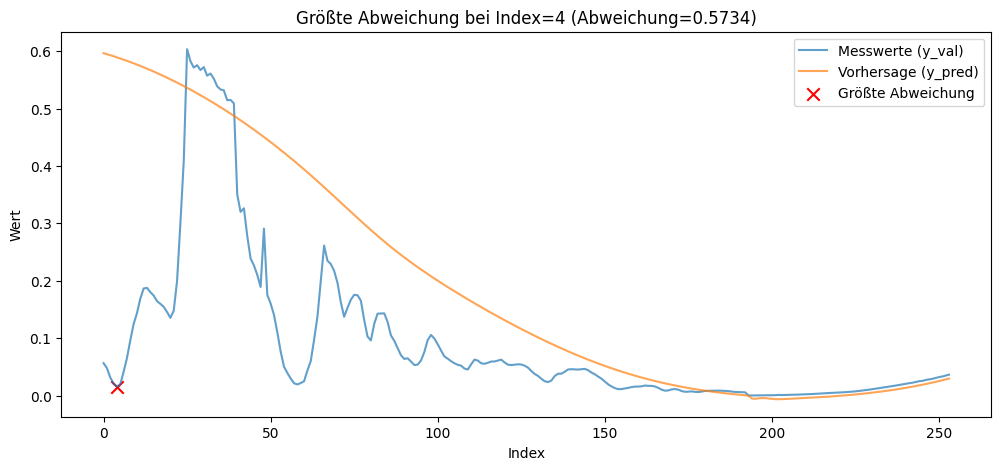

In [67]:
plot_largest_deviation(y_pred, y_test_seq)

In [68]:
print(y_pred, y_test_seq)

[0.5964893  0.5947581  0.59296805 ... 0.02386023 0.02528338 0.02675119] [0.05666824 0.04794793 0.03181067 ... 0.03678404 0.03708798 0.03657019]
